### Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport

#importing packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.under_sampling import ClusterCentroids
from collections import Counter

from imblearn.over_sampling import SMOTE, SMOTEN, SMOTENC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
data = pd.read_csv('data/Claim Denial Updated.csv')
data.shape

In [ ]:
columns_to_remove = ['Unnamed: 0' ,'CLAIM_TYPE', 'CLAIM_ID' , 'CLAIM_LINE_NUMBER', 'ENCOUNTER_ID', 'PATIENT_ID', 'Name',
'CLAIM_START_DATE', 'CLAIM_END_DATE', 'CLAIM_LINE_START_DATE','CLAIM_LINE_END_DATE',
'PLACE_OF_SERVICE_DESCRIPTION','REVENUE_CENTER_DESCRIPTION','RENDERING_NPI',
'FACILITY_NPI','DISCHARGE_DISPOSITION_DESCRIPTION','DATA_SOURCE','COVERAGE_START_DATE',
'COVERAGE_END_DATE','PAYER', 'PAYER_TYPE', 'BIRTH_DATE','ZIP_CODE','DECEASED_FLAG',
'CONDITION_DATE','CONDITION_TYPE','CODE_TYPE','DESCRIPTION','MONTH','YEAR','ENCOUNTER_START_DATE',
'ENCOUNTER_END_DATE','ADMIT_SOURCE_DESCRIPTION','ADMIT_TYPE_DESCRIPTION',
'PROCEDURE_DATE', 'Year','REASON']

### Replace 'Partially Approved' with 'Approved'

In [ ]:
#CLAIM_STATUS: Replace 'Partially Approved' with 'Approved'
data['CLAIM_STATUS'] = data['CLAIM_STATUS'].replace('Partially Approved','Approved')
data['CLAIM_STATUS'].value_counts()

### Set DENIAL_CATEGORY to NOT_APPLICABLE for all 'Approved'  Claims

In [ ]:
#DENIAL_CATEGORY: invalid for approved claims
data['DENIAL_CATEGORY'] = data['DENIAL_CATEGORY'].fillna('NOT_APPLICABLE')
data['DENIAL_CATEGORY'].value_counts()

### PAYERS is not available for Approved Claims. Impute based on the distribution of avaialble payers.

In [ ]:
# Calculate the value counts of non-null values, normalized
value_counts = data['PAYERS'].value_counts(normalize=True)
value_counts

In [ ]:
# Create a list of the categories to fillna with, based on their normalized frequencies
fill_values = list(value_counts.index)
fill_weights = list(value_counts.values)

In [ ]:
print(f'fill_values :{fill_values}')
print(f'fill_weights :{fill_weights}')

In [ ]:
# Fill the NaN values using the weighted random choice of categories
data['PAYERS'] = data['PAYERS'].fillna(pd.Series(np.random.choice(fill_values, size=len(data.index), p=fill_weights)))

In [ ]:
#PAYERS: Not Available for Approved & Partially Approved.
#data['PAYERS'] = data['PAYERS'].fillna('Unknown_Payer')
data['PAYERS'].value_counts()

In [ ]:
print(f'Before imputation: \n {value_counts}')
print('*'*50)

print(f"After imputation: \n {data['PAYERS'].value_counts(normalize=True)}")

### Add a new REASON_CODE='APPROVED' for Approved Claims

In [ ]:
#Add reason code for APPROVED CLAIMs : AP01
#data['REASON_CODE'].value_counts()#.sum()
#data['REASON_CODE'].unique()
#data[data['CLAIM_STATUS'] == 'Approved'].shape
data['REASON_CODE'].fillna('APPROVED', inplace=True)

In [ ]:
data['REASON_CODE'].value_counts()

In [ ]:
4653/data.shape[0]

In [ ]:
data['REASON_CODE'].value_counts().plot(kind='bar')

### Remove insignificant features
- Drop zero variance columns
- Drop Date Columns

In [ ]:
col_removed_df = data.drop(columns_to_remove, axis=1)
col_removed_df.shape

In [ ]:
col_removed_df.describe()

In [ ]:
col_removed_df.info()

### Devide into Categorical and Numerical columns

In [ ]:
numerical_df = col_removed_df.select_dtypes(include='number')
categorical_df = col_removed_df.select_dtypes(include='object')

In [ ]:
numerical_df.shape, categorical_df.shape

In [ ]:
cat_col_from_numerical_df = ['PLACE_OF_SERVICE_CODE' , 'REVENUE_CENTER_CODE', 'DISCHARGE_DISPOSITION_CODE','DUAL_STATUS', 'MEDICARE_STATUS','ADMIT_SOURCE_CODE','ADMIT_TYPE_CODE', 'MS_DRG', 'HIGH_COST_CLAIMANTS']
len(cat_col_from_numerical_df)

In [ ]:
categorcal_cols = categorical_df.columns.tolist()
len(categorcal_cols)

In [ ]:
categorcal_cols.extend(cat_col_from_numerical_df)
len(categorcal_cols)

In [ ]:
categorical_df =  col_removed_df[categorcal_cols]
categorical_df.shape

In [ ]:
numerical_cols = list(set(col_removed_df.columns).difference(set(categorical_df.columns)))
numerical_cols

**NO_OF_MEMBERS_IN_FAMILY** will be investigated again.

In [ ]:
numerical_df = col_removed_df[numerical_cols]
numerical_df.shape

In [ ]:
set(numerical_df.columns).intersection(categorical_df.columns)

In [ ]:
numerical_df.shape, categorical_df.shape

In [ ]:
#Null Check
numerical_df.isna().sum()

In [ ]:
#Null Check
categorical_df.isna().sum()

In [ ]:
data.CLAIM_STATUS.value_counts()

In [ ]:
total_cat_cols = 0
for col in categorical_df.columns:
    #print(col)
    total_cat_cols += len(categorical_df.loc[:,col].value_counts())
print(f'total_cat_cols : {total_cat_cols}')

In [ ]:
#HANDLE NUMERICAL DF
numerical_df.head()

In [ ]:
categorical_df.head()

In [ ]:
merged = pd.concat([numerical_df, categorical_df],axis=1 )
merged.shape

In [ ]:
merged.head()

### Addressing duplicate rows

In [ ]:
merged[merged.duplicated()].shape

In [ ]:
merged.shape

There are 51 duplicate rows. We'll be removing those.

In [ ]:
merged_no_dup = merged.drop_duplicates()
merged_no_dup.shape

### Pandas Profiling to understand the features & their relationships

In [ ]:
#profile = ProfileReport(merged_no_dup, title="CLAIMS DENIAL ANALYSIS",html={"style":{"full_width":True}})
#profile

In [ ]:
#profile.to_file(output_file="output.html")

In [ ]:
len(categorcal_cols)

In [ ]:
categorcal_cols

In [ ]:
pd.get_dummies(merged_no_dup,columns=categorcal_cols,drop_first=True).shape

**HCPCS_CODE** has a high cardinality: 604 distinct values	High cardinality

**COUNTY** has a high cardinality: 306 distinct values	High cardinality

**CODE** has a high cardinality: 1118 distinct values

In [ ]:
merged_no_dup['HCPCS_CODE'].value_counts().plot(kind='bar')

In [ ]:
merged_no_dup['HCPCS_CODE'].value_counts()[:60].plot(kind='bar')

In [ ]:
merged_no_dup['HCPCS_CODE'].value_counts()[:61].index

In [ ]:
merged_no_dup['COUNTY'].value_counts()

In [ ]:
merged_no_dup['CODE'].value_counts()

In [ ]:
def fix_cardinality(merged_no_dup, column, new_value ,in_freq = 30, ):
    # count frequencies of each value in the column
    value_counts = merged_no_dup[column].value_counts()

    # create dictionary mapping values to their frequencies
    freq_dict = dict(value_counts)

    # assign a unique value to all values with frequency less than 30
    for value, freq in freq_dict.items():
        if freq < in_freq:
            merged_no_dup.loc[merged_no_dup[column] == value, column] = new_value 
    return merged_no_dup

In [ ]:
merged_no_dup = fix_cardinality(merged_no_dup,column='HCPCS_CODE', in_freq=30, new_value='85730')
merged_no_dup.shape

In [ ]:
merged_no_dup = fix_cardinality(merged_no_dup,column='COUNTY', in_freq=50, new_value='COUNTY_X')
merged_no_dup.shape

In [ ]:
merged_no_dup = fix_cardinality(merged_no_dup,column='CODE', in_freq=173, new_value="CODE_X")
merged_no_dup.shape

In [ ]:
categorcal_cols_original = categorcal_cols

In [ ]:
categorcal_cols = [col for col in categorcal_cols if col != 'REASON_CODE']
len(categorcal_cols)

In [ ]:
dumy_encoded = pd.get_dummies(merged_no_dup,columns=categorcal_cols,drop_first=True)
dumy_encoded.shape

In [ ]:
dumy_encoded.head()

In [ ]:
dumy_encoded.describe()


In [ ]:
['SERVICE_UNIT_QUANTITY', 'PAID_AMOUNT','NO_OF_MEMBERS_IN_FAMILY']

### Features to be Normalized/Standardized

In [ ]:
norm_features = []
desc = dumy_encoded.describe()
for col in desc.columns:
    if desc.loc[:,col]['std'] > 3:
        norm_features.append(col)
        #print(col)
print(f' Features to be Normalized are : {norm_features}')

### Undersample

In [ ]:
#dumy_encoded.REASON_CODE.value_counts()['APPROVED']
#dumy_encoded.shape[0] - dumy_encoded.REASON_CODE.value_counts()['APPROVED']

#dumy_encoded_undersampled = dumy_encoded[dumy_encoded['REASON_CODE'] == 'APPROVED'].sample(1200)
#dumy_encoded_undersampled.shape
#
#
## Assume the label column is called 'Label'
#df_majority = dumy_encoded[dumy_encoded['REASON_CODE'] == 'APPROVED'].sample(n=1200, random_state=42)
#df_minority = dumy_encoded[dumy_encoded['REASON_CODE'] != 'APPROVED']
#
## Combine the two dataframes
#df_final = pd.concat([df_majority, df_minority], ignore_index=True)
#df_final['REASON_CODE'].value_counts()

### Create X, y 

In [ ]:
X = dumy_encoded.drop(columns='REASON_CODE')
y = dumy_encoded['REASON_CODE']
print(f'X:{X.shape} \n y:{y.shape}')

### Data Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8675309, stratify=y)

In [ ]:
print(f'X_train : {X_train.shape}\n X_test:{X_test.shape}\n y_train:{y_train.shape}\n y_test:{y_test.shape}')

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

### Feature Normalization

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train[norm_features])


In [ ]:
scaled = scaler.transform(X_train[norm_features])
X_train['PAID_AMOUNT'] =  scaled[:,0]
X_train['SERVICE_UNIT_QUANTITY'] =  scaled[:,1]
X_train.shape

In [ ]:
scaled_test = scaler.transform(X_test[norm_features])
X_test['PAID_AMOUNT'] =  scaled_test[:,0]
X_test['SERVICE_UNIT_QUANTITY'] =  scaled_test[:,1]
X_test.shape

### Modeling

#### Logistic Regression

In [ ]:
num_cols = ['SERVICE_UNIT_QUANTITY', 'PAID_AMOUNT','NO_OF_MEMBERS_IN_FAMILY', 'REASON_CODE']
cat_cols = [col for col in X_train.columns  if col not in num_cols] 

In [ ]:
col_indexes = [X_train.columns.get_loc(col) for col in cat_cols ]

In [ ]:
""" smote = SMOTENC(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4,
    categorical_features=col_indexes # indeces of the columns of categorical variables
)  
sm_Xtrain, sm_Ytrain= smote.fit_resample(X_train, y_train)
sm_Xtrain.shape, sm_Ytrain.shape, X_train.shape """

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# assume that y_train contains the true labels for the training data
unique_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=y_train)
print("Class weights:", class_weights)

class_weights = {k:v for k,v in zip(range(len(class_weights)),class_weights)}


In [ ]:
#LOGISTIC REGRESSION

lr_model = LogisticRegression(max_iter=5000, multi_class='multinomial')#, class_weight=class_weights)
lr_model.fit(X_train, y_train)

In [ ]:
preds = lr_model.predict(X_test)
train_preds = lr_model.predict(X_train)

In [ ]:
print(f'LogisticRegression Test Accuracy: {accuracy_score(y_test, preds) * 100:.2f}')
print(f'LogisticRegression Train Accuracy: {accuracy_score(y_train, train_preds) * 100:.2f}')

### Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)#,  class_weight=class_weights)
dt_model.fit(X_train, y_train)

In [ ]:
pred_test= dt_model.predict(X_test)
pred_train= dt_model.predict(X_train)

In [ ]:
print(f'DecisionTreeClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'DecisionTreeClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

In [ ]:
#Visualizing a Decision Tree
#from sklearn.tree import plot_tree, export_text
#plt.figure(figsize =(80,20))

#plot_tree(dt_model, feature_names=X_train.columns, max_depth=5, filled=True)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state = 24, n_jobs = -1)#,  class_weight=class_weights)
rf_model.fit(X_train, y_train)

In [ ]:
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

In [ ]:
print(f'RandomForestClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'RandomForestClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

### Classification report

In [ ]:
y_hat_train = lr_model.predict(X_train)
y_hat_test = lr_model.predict(X_test)
print(f'{lr_model} Test Classification report: {classification_report(y_test, y_hat_test)}')
print(f'{lr_model} Train Accuracy Classification report: {classification_report(y_train, y_hat_train)}')

In [ ]:
y_hat_train = dt_model.predict(X_train)
y_hat_test = dt_model.predict(X_test)
print(f'{dt_model} Test Classification report: {classification_report(y_test, y_hat_test)}')
print(f'{dt_model} Train Accuracy Classification report: {classification_report(y_train, y_hat_train)}')

In [ ]:
y_hat_train = rf_model.predict(X_train)
y_hat_test = dt_model.predict(X_test)
print(f'{rf_model} Test Classification report: {classification_report(y_test, y_hat_test)}')
print(f'{rf_model} Train Accuracy Classification report: {classification_report(y_train, y_hat_train)}')

In [ ]:
#1. Anomaly Detection
#2. Imbalance
#3. Improve the classification models.

### SVC

In [ ]:
from sklearn.svm  import SVC

In [ ]:
svc = SVC(kernel='rbf')
svc.fit(X_train,y_train)

In [ ]:
preds = svc.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

In [ ]:
confusion_matrix(y_test, preds)

### Hyperparamet Tuning

#### Decision Tree + GridSerachCV

In [ ]:
#clf = DecisionTreeClassifier(random_state=123)
#
# Create grid parameters for hyperparameter tuning
#
params =  {
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [1, 2, 3,4,5,6,7,8,9],
    'criterion':['gini', 'entropy', 'log_loss'],
}
# Create gridsearch instance
#
grid = GridSearchCV(estimator=dt_model,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)
#
# Fit the model
#
grid.fit(X_train, y_train)
outs = grid.predict(X_test)
accuracy_score(y_test,outs)
#
# Assess the score
#
grid.best_score_, grid.best_params_

In [ ]:
#ValueError: Invalid parameter 'class_weights' for estimator DecisionTreeClassifier(random_state=42). 
#Valid parameters are: ['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes',
# 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'].

#### RandomForest GridSearchCV

In [ ]:
#Randim Forest
#
# Create grid parameters for hyperparameter tuning
#
params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40],#, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800]#, 1000, 1200, 1400, 1600, 1800, 2000]
    }

# Create gridsearch instance
#
grid = GridSearchCV(estimator=rf_model,
                    param_grid=params,
                    cv=10,
                    n_jobs=1,
                    verbose=2)
#
# Fit the model
#
grid.fit(X_train, y_train)
#
# Assess the score
#
grid.best_score_, grid.best_params_

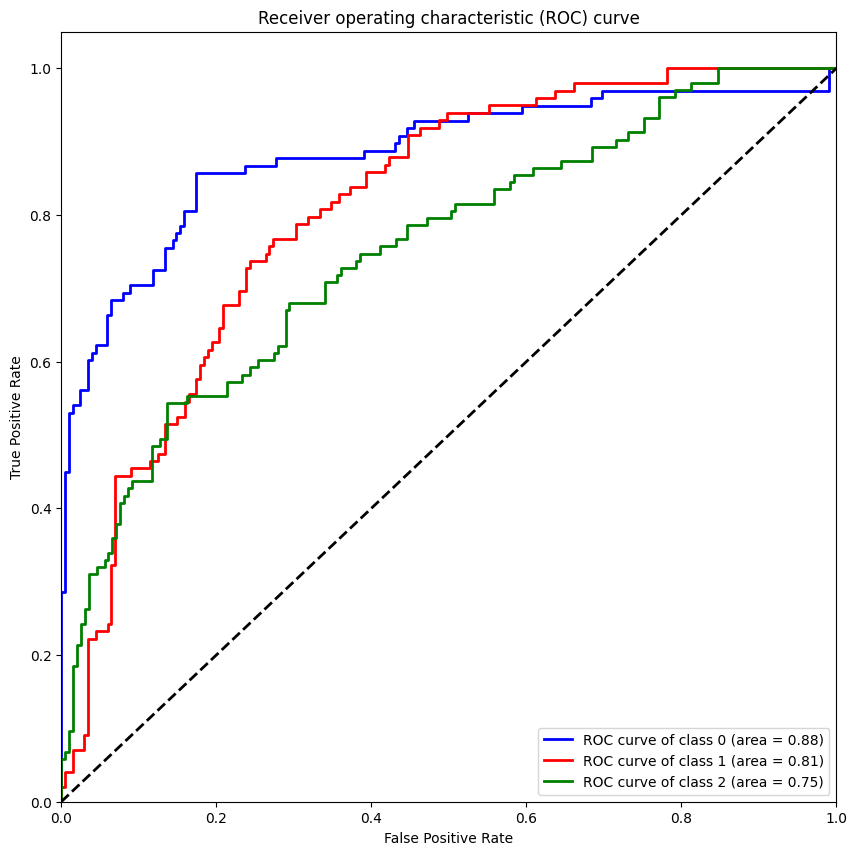

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Generate a random multiclass classification dataset
X, y = make_classification(n_samples=1000, n_classes=3, n_informative=4, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Import a classifier (e.g. logistic regression) and fit it to the training data
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Predict the probabilities for the test data
y_score = clf.predict_proba(X_test)

# Binarize the labels (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calculate the ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10,10))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()
